<a href="https://colab.research.google.com/github/leedain0301/Data_MiniProject_02/blob/main/MiniProject_02_%EC%A0%84%EC%B2%98%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아파트 실거래가 예측


> 한국의 주거 형태는 약 50%가 아파트이고, 
> 재태크 수단으로서도 아파트 매매가에 관심도가 높습니다.
>
>아파트 실거래가 예측 데이터 분석은 중개사와 구매자를 연결하여 부동산정보 서비스 시장의 신뢰도를 높이고, 아파트 구매자들의 정보 불균형을 해결하기 위해 미래의 실 거래가 예측을 목표로 합니다.
>
> 이 데이터는 부동산 기업 앱 '직방'에서 데이터를 제공 받았고, 서울 아파트 실거래가 2008 ~ 2017년도 정보를 가지고 있습니다.





## 컬럼 설명

###   train.csv / test.csv <br>
>  : 서울 지역의 740,000여개 거래 데이터, 아파트 거래일, 지역, 전용면적, 실 거래가 등의 정보

- **features**
  *   transaction_id : 아파트 거래 유일키키
  *   apartment_id : 아파트 아이디
  *   city : 도시
  *   dong : 동
  *   jibun : 지번
  *   apt : 아파트단지 이름
  *   addr_kr : 주소
  *   exclusive_use_area : 전용면적
  *   year_of_completion : 설립일자
  *   transaction_year_month : 거래년월
  *   transaction_date : 거래날짜
  *   floor : 층
  *   transaction_real_price : 실거래가(train 만 존재)



<br>

---

<br>









In [93]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import sklearn
from sklearn.linear_model    import ElasticNet, Lasso
from sklearn.ensemble        import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge    import KernelRidge
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import RobustScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics         import mean_squared_error, accuracy_score

from category_encoders       import OneHotEncoder, OrdinalEncoder

import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import sys

In [95]:
train_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/test.csv')
submission_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/submission.csv')

print('train.csv. Shape: ',train_data.shape)
print('test.csv. Shape: ', test_data.shape)

train.csv. Shape:  (1216553, 13)
test.csv. Shape:  (5463, 12)


In [96]:
# 서울/부산->부산 데이터 삭제
train_data.drop(train_data[(train_data['city'] == '부산광역시')].index, inplace=True)
test_data.drop(test_data[(test_data['city'] == '부산광역시')].index, inplace=True)

In [97]:
# train_data.head()

In [98]:
# test_data.head()

In [99]:
# train_data.info()

In [100]:
# test_data.info()

In [101]:
train_data.duplicated().sum()

0

In [102]:
test_data.duplicated().sum()

0

In [103]:
train_null = train_data.drop('transaction_real_price', axis=1).isnull().sum()/len(train_data)*100
test_null = test_data.isnull().sum()/len(test_data)*100
pd.DataFrame({'train_null_count': train_null,'test_null_count':test_null})

,train_null_count,test_null_count
transaction_id,0.0,0.0
apartment_id,0.0,0.0
city,0.0,0.0
dong,0.0,0.0
jibun,0.0,0.0
apt,0.0,0.0
addr_kr,0.0,0.0
exclusive_use_area,0.0,0.0
year_of_completion,0.0,0.0
transaction_year_month,0.0,0.0


In [104]:
train_data.nunique()

transaction_id            742285
apartment_id                8251
city                           1
dong                         330
jibun                       6119
apt                         6917
addr_kr                     8251
exclusive_use_area         12475
year_of_completion            54
transaction_year_month       119
transaction_date               6
floor                         73
transaction_real_price     12301
dtype: int64

<br>

---
<br>

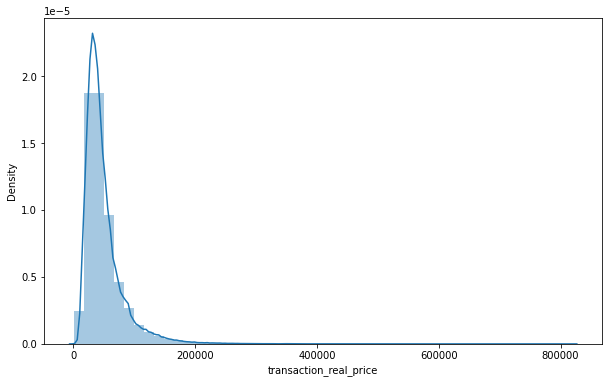

In [105]:
f,ax=plt.subplots(figsize=(10,6))
sns.distplot(train_data['transaction_real_price'])

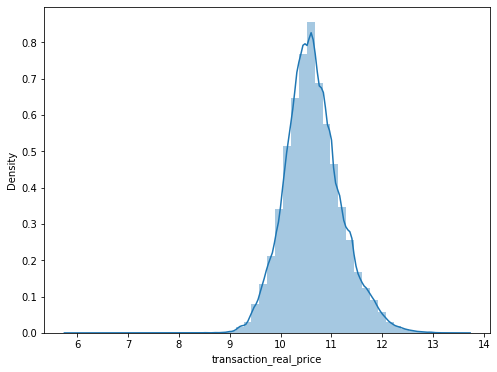

In [106]:
train_data['transaction_real_price'] = np.log1p(train_data['transaction_real_price'])
real_price = train_data['transaction_real_price']
f,ax=plt.subplots(figsize=(8,6))
sns.distplot(train_data['transaction_real_price'])

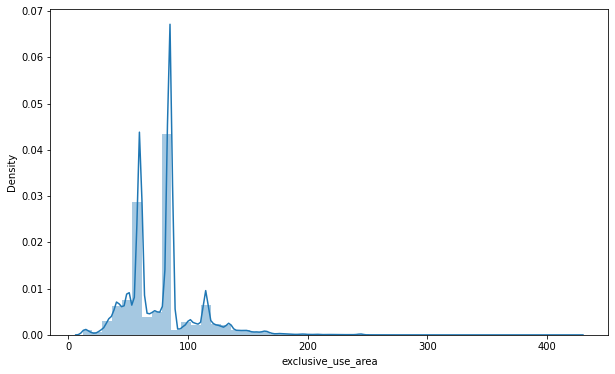

In [107]:
f,ax=plt.subplots(figsize=(10,6))
sns.distplot(train_data['exclusive_use_area'])

In [108]:
train_data['exclusive_use_area'] = np.log1p(train_data['exclusive_use_area'])
test_data['exclusive_use_area'] = np.log1p(test_data['exclusive_use_area'])
area  = train_data['exclusive_use_area']

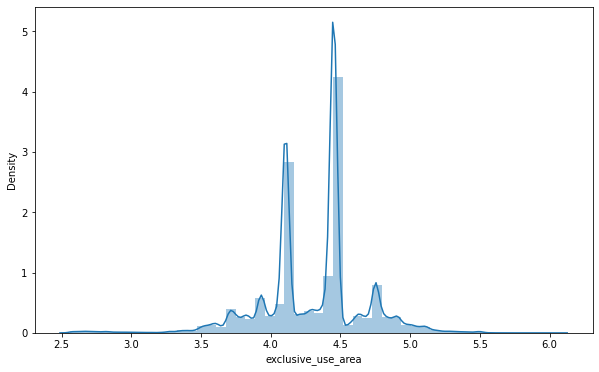

In [109]:
f,ax=plt.subplots(figsize=(10,6))
sns.distplot(train_data['exclusive_use_area'])

In [110]:
# 필요없는 컬럼 삭제
drop_columns=['transaction_id','apartment_id','city','jibun','apt','addr_kr']

train_drop = train_data[drop_columns]
test_drop = test_data[drop_columns]

train = train_data.drop(drop_columns,axis=1)
test = test_data.drop(drop_columns,axis=1)
test.head()

,dong,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,목동,3.598681,2002,201711,11~20,2
3,대치동,4.723309,2004,201707,1~10,10
6,염창동,4.453300,2004,201711,1~10,13
7,암사동,4.638025,2008,201712,21~31,9
8,신정동,4.673389,1987,201712,11~20,4


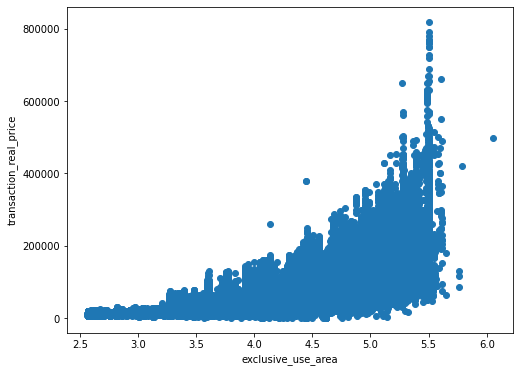

In [111]:
train['transaction_real_price'] = np.expm1(train_data['transaction_real_price'])

f,ax=plt.subplots(figsize=(8,6))
plt.scatter(train['exclusive_use_area'],train['transaction_real_price'])
plt.xlabel('exclusive_use_area')
plt.ylabel('transaction_real_price')
plt.show()

In [112]:
train_data['transaction_real_price'] = np.log1p(train_data['transaction_real_price'])

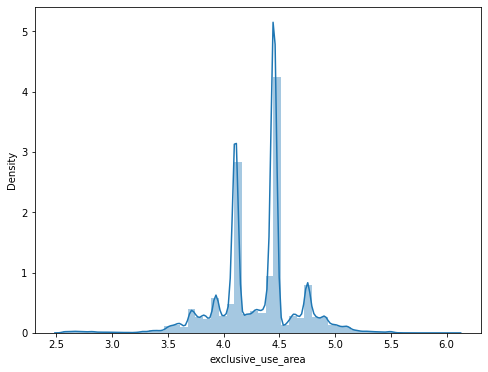

In [113]:
f,ax=plt.subplots(figsize=(8,6))
sns.distplot(train['exclusive_use_area'])

In [114]:
# train[train['floor'] < 0].head() #오마이갓...지하가 있었어...

floor->Skewness: 0.032724, Kurtosis: -0.670766


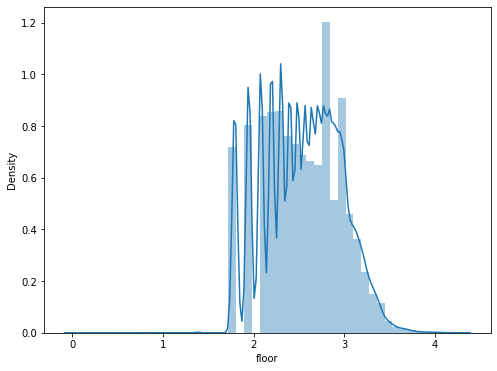

In [115]:
# floor에 log처리

train['floor']=np.log(train['floor']+5)
test['floor']=np.log(test['floor']+5)
f,ax=plt.subplots(figsize=(8,6))
sns.distplot(train['floor'])
print("%s->Skewness: %f, Kurtosis: %f"%('floor',train['floor'].skew(),train['floor'].kurt()))

In [116]:
train_test_data=[train,test]
for dataset in train_test_data:
    dataset['transaction_year_month']=dataset['transaction_year_month'].astype(str)
    dataset['year']=dataset['transaction_year_month'].str[:4].astype(int)
    dataset['month']=dataset['transaction_year_month'].str[4:6].astype(int)
    dataset['transaction_year_month']=dataset['transaction_year_month'].astype(int)

In [117]:
train = train.drop('transaction_year_month',axis=1)
test = test.drop('transaction_year_month',axis=1)
train.head()

,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,year,month
0,신교동,4.452252,2002,21~31,1.945910,37500.0,2008,1
1,필운동,4.606869,1973,1~10,2.397895,20000.0,2008,1
2,필운동,4.451319,2007,1~10,2.397895,38500.0,2008,1
3,내수동,4.993082,2003,11~20,2.995732,118000.0,2008,1
4,내수동,5.275202,2004,21~31,2.079442,120000.0,2008,1


In [118]:
train_dong=train[['transaction_real_price','dong']].groupby('dong').mean().sort_values('transaction_real_price').reset_index()
train_dong.head()

,dong,transaction_real_price
0,장충동2가,6628.421053
1,필동1가,8466.666667
2,누상동,10650.000000
3,영등포동3가,11515.652174
4,영등포동2가,12402.040816


In [119]:
dong_num={}
for i in range(len(train_dong)):
    dong=train_dong['dong'].iloc[i]
    dong_num[dong]=i
dong_num

{'장충동2가': 0,
 '필동1가': 1,
 '누상동': 2,
 '영등포동3가': 3,
 '영등포동2가': 4,
 '미근동': 5,
 '오장동': 6,
 '영등포동4가': 7,
 '영등포동1가': 8,
 '행촌동': 9,
 '안암동4가': 10,
 '당산동6가': 11,
 '통인동': 12,
 '충신동': 13,
 '연건동': 14,
 '동숭동': 15,
 '성북동': 16,
 '남창동': 17,
 '효제동': 18,
 '명륜3가': 19,
 '인현동2가': 20,
 '대조동': 21,
 '노고산동': 22,
 '안암동3가': 23,
 '만리동2가': 24,
 '익선동': 25,
 '원효로2가': 26,
 '동소문동6가': 27,
 '가리봉동': 28,
 '영등포동5가': 29,
 '쌍문동': 30,
 '묵정동': 31,
 '삼선동5가': 32,
 '충무로5가': 33,
 '상계동': 34,
 '신영동': 35,
 '갈현동': 36,
 '가산동': 37,
 '낙원동': 38,
 '동선동4가': 39,
 '신월동': 40,
 '번동': 41,
 '도봉동': 42,
 '독산동': 43,
 '원효로3가': 44,
 '수유동': 45,
 '월계동': 46,
 '화양동': 47,
 '신내동': 48,
 '시흥동': 49,
 '구산동': 50,
 '상도1동': 51,
 '공릉동': 52,
 '창천동': 53,
 '오류동': 54,
 '중곡동': 55,
 '망우동': 56,
 '궁동': 57,
 '방학동': 58,
 '신설동': 59,
 '문래동2가': 60,
 '이화동': 61,
 '산림동': 62,
 '면목동': 63,
 '구로동': 64,
 '부암동': 65,
 '창동': 66,
 '방화동': 67,
 '중화동': 68,
 '역촌동': 69,
 '보문동6가': 70,
 '양평동2가': 71,
 '보문동2가': 72,
 '당산동2가': 73,
 '사근동': 74,
 '동소문동4가': 75,
 '능동': 76,
 '문래동6가': 77,
 '정릉동': 78,
 '회기동'

In [120]:
train=train.replace({'dong': dong_num})
test=test.replace({'dong':dong_num})
train.head()

,dong,exclusive_use_area,year_of_completion,transaction_date,floor,transaction_real_price,year,month
0,192,4.452252,2002,21~31,1.945910,37500.0,2008,1
1,264,4.606869,1973,1~10,2.397895,20000.0,2008,1
2,264,4.451319,2007,1~10,2.397895,38500.0,2008,1
3,316,4.993082,2003,11~20,2.995732,118000.0,2008,1
4,316,5.275202,2004,21~31,2.079442,120000.0,2008,1


In [121]:
# 스케일링
scaler = StandardScaler()

numeric_feats = train.dtypes[train.dtypes != "object"].index
numeric_feats_2 = test.dtypes[test.dtypes != "object"].index

train[numeric_feats] = scaler.fit_transform(train[numeric_feats])
test[numeric_feats_2] = scaler.fit_transform(test[numeric_feats_2])

In [122]:
# 인코딩
encoder = OrdinalEncoder()

train = encoder.fit_transform(train) 
test = encoder.fit_transform(test) 

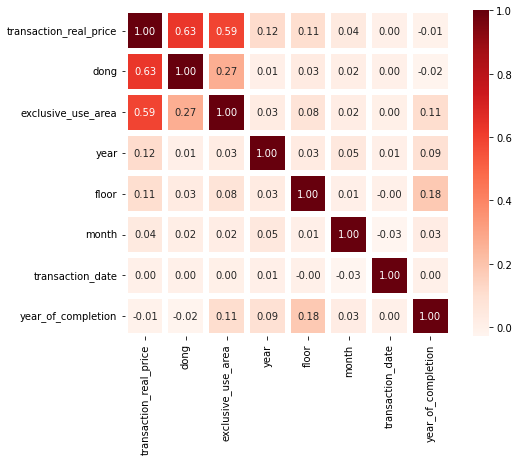

In [123]:
k=train.shape[1]
corrmat=train.corr()
cols=corrmat.nlargest(k,'transaction_real_price')['transaction_real_price'].index
cm=np.corrcoef(train[cols].values.T)
f,ax=plt.subplots(figsize=(8,6))
sns.heatmap(data=cm,annot=True,square=True,fmt='.2f',linewidths=5,cmap='Reds',yticklabels=cols.values,xticklabels=cols.values)


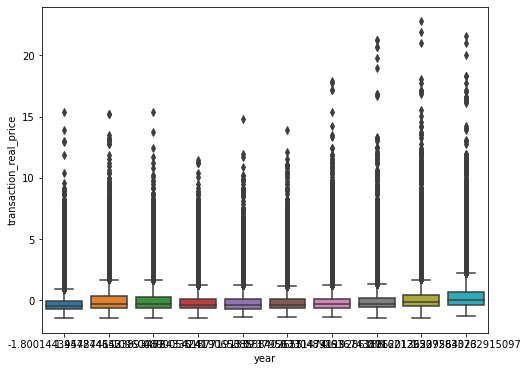

In [88]:
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(train['year'],train['transaction_real_price'])
plt.show()

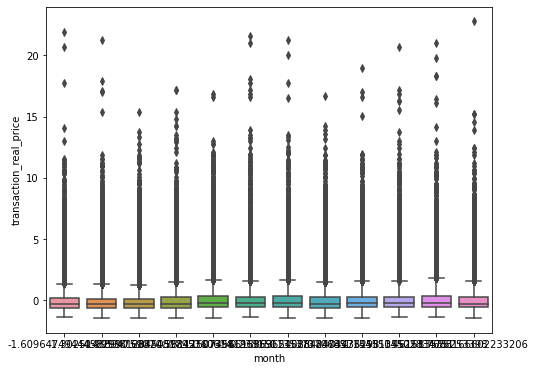

In [89]:
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(train['month'],train['transaction_real_price'])
plt.show()

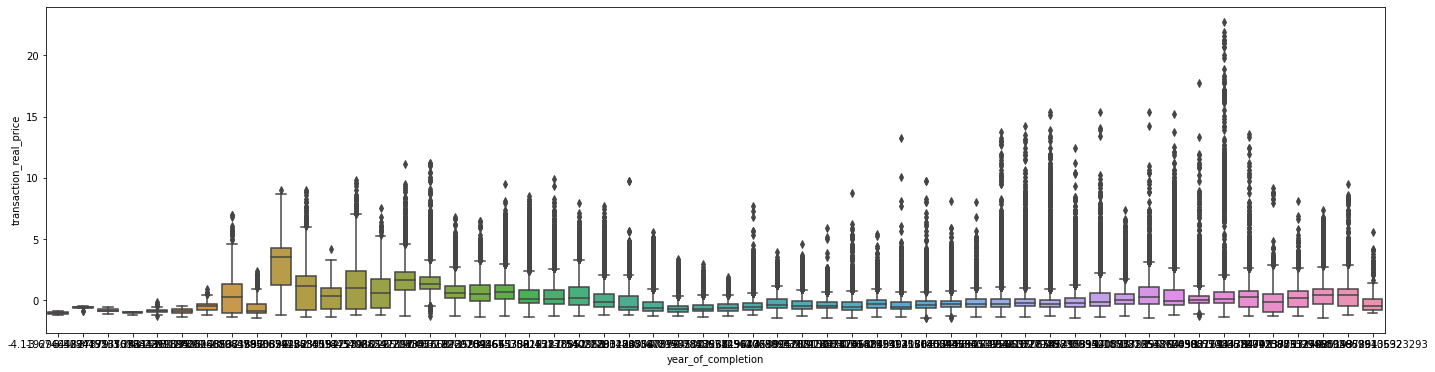

In [90]:
f,ax=plt.subplots(figsize=(24,6))
sns.boxplot(train['year_of_completion'],train['transaction_real_price'])
plt.show()

In [91]:
# 이상치 확인용용
# train[train['year_of_completion']==1999].sort_values('transaction_real_price',ascending=True)

In [92]:
train.to_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/train_clean.csv', index=False, header=True)
test.to_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/test_clean.csv', index=False, header=True)